# Data

## *Loading*

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

In [ ]:
!pip3 install --quiet "tensorflow-text==2.8.*"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
data_dir = "/content/drive/MyDrive/ECS 271 Project/"
data = pd.read_csv(data_dir + "WELFake_Dataset.csv")
adv1 = pd.read_csv(data_dir + "advDataRandom-2.csv", encoding='latin-1')
adv2 = pd.read_csv(data_dir + "advDataKey.csv", encoding='latin-1')
adv3 = pd.read_csv(data_dir + "advDataAppend.csv", encoding='latin-1')

## *Preprocessing*

In [ ]:
# changing NaNs to empty strings
data[data["title"].isna()]["title"] = ""
data[data["text"].isna()]["text"] = ""

adv1[adv1["title"].isna()]["title"] = ""
adv1[adv1["text"].isna()]["text"] = ""

adv2[adv2["title"].isna()]["title"] = ""
adv2[adv2["text"].isna()]["text"] = ""

adv3[adv3["title"].isna()]["title"] = ""
adv3[adv3["text"].isna()]["text"] = ""

In [ ]:
# the default train-test split it 75-25
del data["text"]
del adv1["text"]
del adv2["text"]
del adv3["text"]

train, test = train_test_split(data, random_state = 42) # split normal data 75/25
advSample = adv1.sample(18033) # adversarial sample
adv_train, test_Rand = train_test_split(advSample, random_state = 42) # split adv sample 75/25
test_Key = adv2.sample(4508) # Key adv test sample
test_Append = adv3.sample(4508) # Append adv test sample

train = pd.concat([train, adv_train], ignore_index=True) # total training data
test_Rand = pd.concat([test, test_Rand], ignore_index=True) # total testing Rand
test_Key = pd.concat([test, test_Key], ignore_index=True) # total testing Key
test_Append = pd.concat([test, test_Append], ignore_index=True) # total testing Append

In [ ]:
def get_dataset(data):
  titles = np.array(data["title"].astype(str))
  # text = np.array(data["text"].astype(str))
  label = np.array(data["label"]).astype('float32')
  return titles, label

In [ ]:
print('data size', len(data))
print('real',sum(data['label'] == 1))
print('fake',sum(data['label'] == 0))
print('train size', len(train))
print('test size', len(test))

data size 72134
real 37106
fake 35028
train size 67624
test size 18034


In [ ]:
X_train, y_train = get_dataset(train)
X_test, y_test = get_dataset(test)
X_test_Rand, y_test_Rand = get_dataset(test_Rand)
X_test_Key, y_test_Key = get_dataset(test_Key)
X_test_Append, y_test_Append = get_dataset(test_Append)

# Model

## *Definition*

In [ ]:
tfhub_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
tfhub_bert = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

In [ ]:
class BERTTextClassifier(tf.keras.Model):
  def __init__(self):
    super(BERTTextClassifier, self).__init__()
    self.title_input = tf.keras.layers.InputLayer(dtype=tf.string)
    self.preprocess = hub.KerasLayer(tfhub_preprocess, name="preprocess")
    self.bert_encoder = hub.KerasLayer(tfhub_bert, name="bert_encoder")
    self.dense_layer = tf.keras.layers.Dense(128, activation='relu')
    self.classifier = tf.keras.layers.Dense(1, activation='sigmoid')

  def call(self, inputs):
    title, text = inputs
    x = self.bert_encoder(self.preprocess(self.title_input(title)))['pooled_output']
    x = self.dense_layer(x)
    return self.classifier(x)

In [ ]:
def build_bert_classifier_model():
    title_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name="title_input")
    preprocess = hub.KerasLayer(tfhub_preprocess, name="preprocess")
    bert_encoder = hub.KerasLayer(tfhub_bert, name="bert_encoder")
    dense_layer = tf.keras.layers.Dense(128, activation='relu')
    classifier = tf.keras.layers.Dense(1, activation='sigmoid')

    x = bert_encoder(preprocess(title_input))['pooled_output']
    x = dense_layer(x)
    output = classifier(x)
    return tf.keras.Model(title_input, output)

## *Training*

In [ ]:
model = build_bert_classifier_model()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

In [ ]:
history = model.fit(x=X_train, y=y_train, epochs=10)

Epoch 1/10
2114/2114 [==============================] - 225s 103ms/step - loss: 0.3350 - binary_accuracy: 0.8518
Epoch 2/10
2114/2114 [==============================] - 217s 103ms/step - loss: 0.2822 - binary_accuracy: 0.8770
Epoch 3/10
2114/2114 [==============================] - 217s 103ms/step - loss: 0.2637 - binary_accuracy: 0.8852
Epoch 4/10
2114/2114 [==============================] - 216s 102ms/step - loss: 0.2503 - binary_accuracy: 0.8931
Epoch 5/10
2114/2114 [==============================] - 220s 104ms/step - loss: 0.2404 - binary_accuracy: 0.8974
Epoch 6/10
2114/2114 [==============================] - 215s 102ms/step - loss: 0.2308 - binary_accuracy: 0.9018
Epoch 7/10
2114/2114 [==============================] - 216s 102ms/step - loss: 0.2235 - binary_accuracy: 0.9044
Epoch 8/10
2114/2114 [==============================] - 214s 101ms/step - loss: 0.2155 - binary_accuracy: 0.9088
Epoch 9/10
2114/2114 [==============================] - 214s 101ms/step - loss: 0.2089 - binary_

## *Evaluating*

In [ ]:
model.evaluate(x = X_test_Rand, y = y_test_Rand)
model.evaluate(x = X_test_Key, y = y_test_Key)
model.evaluate(x = X_test_Append, y = y_test_Append)
model.evaluate(x = X_test, y = y_test)

564/564 [==============================] - 61s 108ms/step - loss: 0.2225 - binary_accuracy: 0.9077


[0.22254008054733276, 0.9077298641204834]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

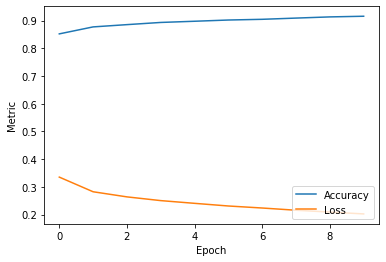

In [ ]:
## plot metrics over epochs
from google.colab import files
model_name = "advDataRandom"
title = model_name + " Accuracy"
save_file = title.replace(" ", "_").lower() + ".png"
plt.plot(history.history['binary_accuracy'], label='Accuracy')
plt.plot(history.history['loss'], label = 'Loss')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend(loc='lower right')
plt.savefig(save_file)
files.download(save_file)

In [ ]:
history.history['loss']

[0.3350410759449005,
 0.28219062089920044,
 0.26372048258781433,
 0.2502518594264984,
 0.24043194949626923,
 0.23082305490970612,
 0.22354447841644287,
 0.21554040908813477,
 0.2088659554719925,
 0.20224535465240479]

In [ ]:
history.history['binary_accuracy']

[0.8518425226211548,
 0.8769963383674622,
 0.8851886987686157,
 0.8930853009223938,
 0.8973885178565979,
 0.901839554309845,
 0.9043978452682495,
 0.9088193774223328,
 0.9130781888961792,
 0.9154590368270874]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

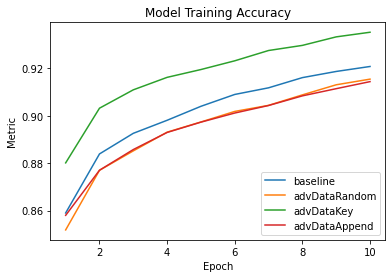

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

model_name = "advDataRandom"
title = "Model Training Accuracy"
save_file = title.replace(" ", "_").lower() + ".png"
epoch_x = list(range(1,11))
plt.title(title)
plt.plot(epoch_x,base_accuracy, label = 'baseline')
plt.plot(epoch_x, accuracy_rand, label = 'advDataRandom')
plt.plot(epoch_x, accuracy_key, label = 'advDataKey')
plt.plot(epoch_x, accuracy_append, label = 'advDataAppend')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend(loc='lower right')
plt.savefig(save_file)
files.download(save_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

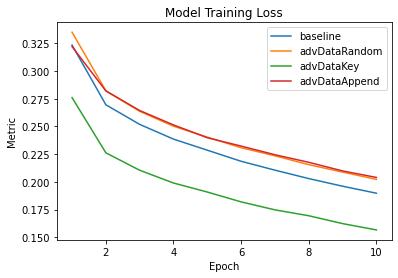

In [ ]:
model_name = "advDataRandom"
title = "Model Training Loss"
save_file = title.replace(" ", "_").lower() + ".png"
plt.title(title)
plt.plot(epoch_x, base_loss, label = 'baseline')
plt.plot(epoch_x, loss_rand, label = 'advDataRandom')
plt.plot(epoch_x, loss_key, label = 'advDataKey')
plt.plot(epoch_x, loss_append, label = 'advDataAppend')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend(loc='upper right')
plt.savefig(save_file)
files.download(save_file)

In [ ]:
y_pred_probs1 = model.predict(X_test_Rand)
y_pred_probs2 = model.predict(X_test_Key)
y_pred_probs3 = model.predict(X_test_Append)

In [ ]:
y_pred1 = (y_pred_probs1 > 0.5).astype(np.float32)[:,0]
y_pred2 = (y_pred_probs2 > 0.5).astype(np.float32)[:,0]
y_pred3 = (y_pred_probs3 > 0.5).astype(np.float32)[:,0]

In [ ]:
np.sum(y_pred1 == y_test_Rand) / y_pred1.shape[0]
np.sum(y_pred2 == y_test_Key) / y_pred2.shape[0]
np.sum(y_pred3 == y_test_Append) / y_pred3.shape[0]

0.9008073817762399

In [ ]:
precision1, recall1, thresholds = precision_recall_curve(y_test_Rand, y_pred_probs1)
precision2, recall2, thresholds = precision_recall_curve(y_test_Key, y_pred_probs2)
precision3, recall3, thresholds = precision_recall_curve(y_test_Append, y_pred_probs3)

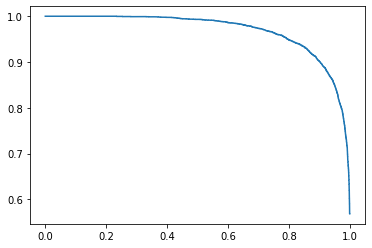

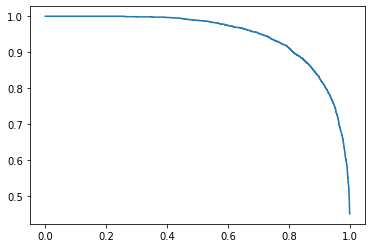

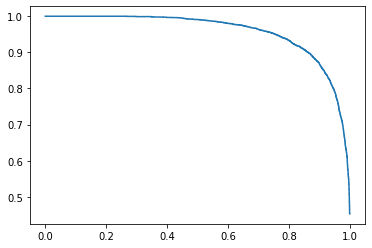

In [ ]:
plt.figure()
plt.plot(recall1, precision1)

plt.figure()
plt.plot(recall2, precision2)

plt.figure()
plt.plot(recall3, precision3)

In [ ]:
print('rand auc', auc(recall1, precision1))
print('key auc', auc(recall2, precision2))
print('append auc', auc(recall3, precision3))

rand auc 0.9684904249113259
key auc 0.9469248317548417
append auc 0.9569087385906725
